In [1]:
%pip install -q torch torchvision numpy nibabel tqdm scikit-learn scikit-image scipy matplotlib pandas opencv-python requests albumentations seaborn tensorboard


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import tarfile
import requests
from pathlib import Path
from datetime import datetime
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import albumentations as A
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import confusion_matrix

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


PyTorch version: 2.7.1+cpu
CUDA available: False


In [12]:
PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"
DATASET_NAME = "Task06_Lung"
RAW_DATA_DIR = DATA_DIR / DATASET_NAME
IMAGES_TR_DIR = RAW_DATA_DIR / "imagesTr"
LABELS_TR_DIR = RAW_DATA_DIR / "labelsTr"
DOWNLOAD_URL = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task06_Lung.tar"
DATASET_TAR_FILE = DATA_DIR / "Task06_Lung.tar"
CHECKPOINT_DIR = PROJECT_ROOT / "checkpoints"
LOG_DIR = PROJECT_ROOT / "logs"
VISUALIZATION_DIR = PROJECT_ROOT / "visualizations"

BATCH_SIZE = 4
LEARNING_RATE = 1e-3
NUM_EPOCHS = 100
NUM_WORKERS = 0
TRAIN_SPLIT, VAL_SPLIT, TEST_SPLIT = 0.8, 0.1, 0.1
IN_CHANNELS, NUM_CLASSES, BASE_CHANNEL_COUNT = 1, 2, 32
USE_AMP = True
EARLY_STOPPING_PATIENCE = 15
DICE_LOSS_WEIGHT, CE_LOSS_WEIGHT = 0.5, 0.5

for d in [DATA_DIR, CHECKPOINT_DIR, LOG_DIR, VISUALIZATION_DIR]:
    d.mkdir(parents=True, exist_ok=True)
DEVICE = torch.device("cpu")
USE_AMP = False
print(f"Using device: {DEVICE}")


Using device: cpu


In [13]:
def download_file(url, dest_path):
    dest_path = Path(dest_path)
    dest_path.parent.mkdir(parents=True, exist_ok=True)
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    with open(dest_path, 'wb') as f, tqdm(desc=dest_path.name, total=total_size, unit='B', unit_scale=True, unit_divisor=1024) as pbar:
        for data in response.iter_content(chunk_size=1024):
            f.write(data)
            pbar.update(len(data))
    print("Download complete.")

if RAW_DATA_DIR.exists():
    print("Data already exists.")
else:
    if not DATASET_TAR_FILE.exists():
        download_file(DOWNLOAD_URL, str(DATASET_TAR_FILE))
    else:
        print("Tar file already exists.")
    print("Extracting...")
    with tarfile.open(DATASET_TAR_FILE, 'r') as tar:
        tar.extractall(path=DATA_DIR)
    print("Extraction complete.")

image_files = sorted([p for p in IMAGES_TR_DIR.glob("*.nii.gz") if not p.name.startswith("._")])
label_files = sorted([p for p in LABELS_TR_DIR.glob("*.nii.gz") if not p.name.startswith("._")])
image_files = [str(p) for p in image_files]
label_files = [str(p) for p in label_files]
print(f"Found {len(image_files)} image files, {len(label_files)} label files")


Data already exists.
Found 63 image files, 63 label files


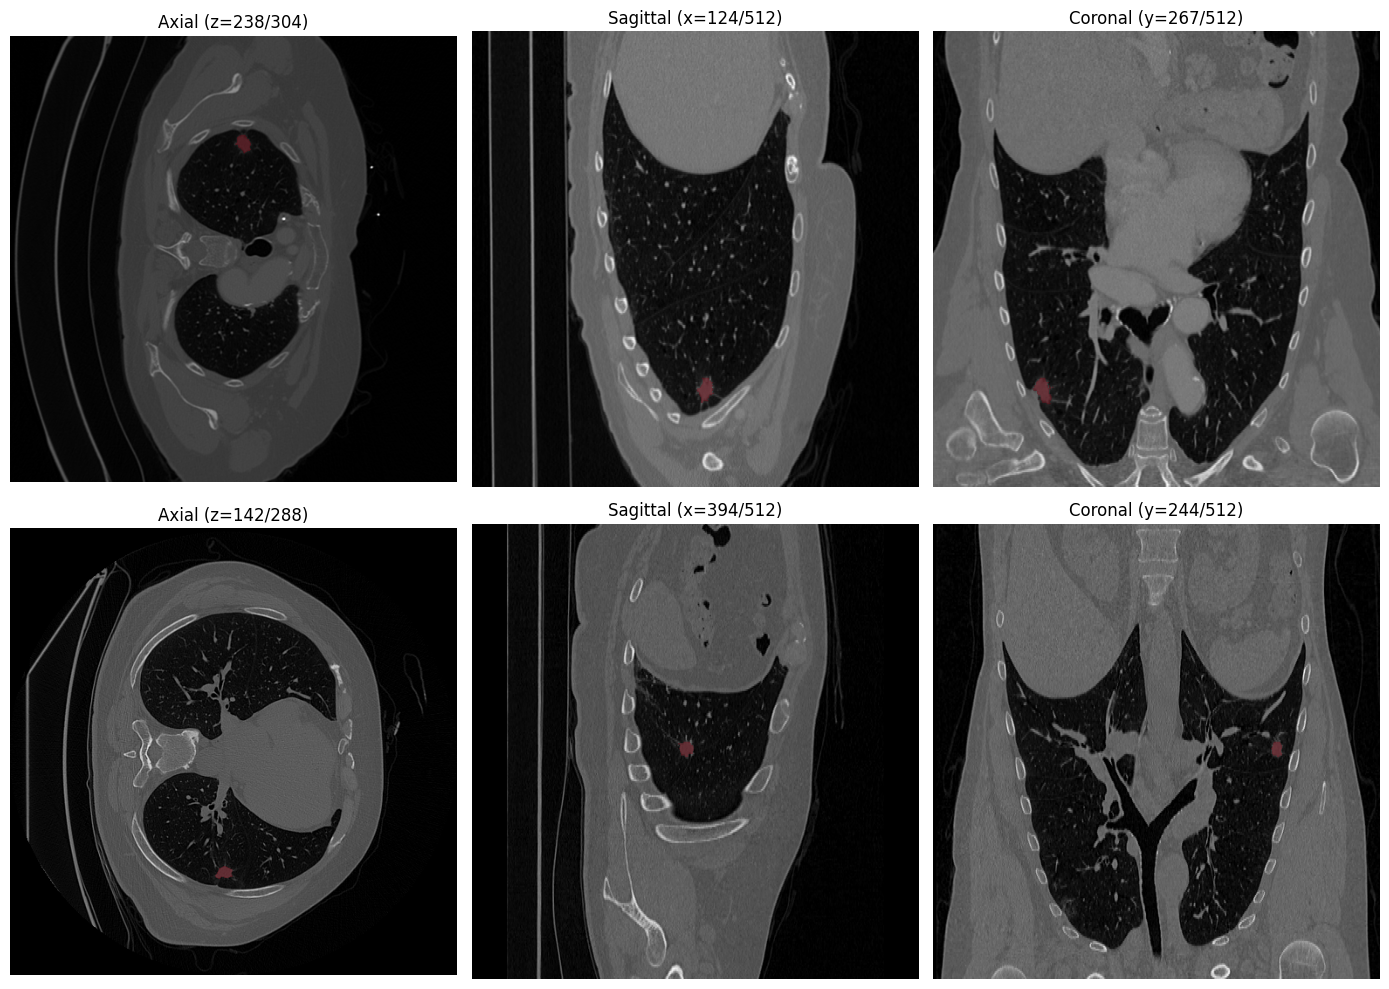

In [19]:
def norm(x):
    x = np.asarray(x, dtype=float)
    lo, hi = np.nanmin(x), np.nanmax(x)
    return (x - lo) / (hi - lo + 1e-8)

n_samples = min(2, len(image_files))
fig, axes = plt.subplots(n_samples, 3, figsize=(14, 5 * n_samples))
if n_samples == 1:
    axes = axes.reshape(1, -1)

for i in range(n_samples):
    img_vol = nib.load(image_files[i]).get_fdata()
    mask_bin = (nib.load(label_files[i]).get_fdata() > 0.5).astype(np.float32)
    H, W, D = img_vol.shape
    coords = np.argwhere(mask_bin > 0.5)
    if len(coords) > 0:
        mx, my, mz = coords.mean(axis=0).astype(int)
    else:
        mz, mx, my = D // 2, H // 2, W // 2

    axes[i, 0].imshow(norm(img_vol[:, :, mz]), cmap="gray")
    axes[i, 0].imshow(np.ma.masked_where(mask_bin[:, :, mz] < 0.5, mask_bin[:, :, mz]), cmap="Reds", alpha=0.5, vmin=0, vmax=1)
    axes[i, 0].set_title(f"Axial (z={mz}/{D})")
    axes[i, 0].axis("off")

    sag = np.transpose(img_vol[mx, :, :], (1, 0))
    sag_m = np.transpose(mask_bin[mx, :, :], (1, 0))
    axes[i, 1].imshow(norm(sag), cmap="gray", aspect="auto")
    axes[i, 1].imshow(np.ma.masked_where(sag_m < 0.5, sag_m), cmap="Reds", alpha=0.5, vmin=0, vmax=1, aspect="auto")
    axes[i, 1].set_title(f"Sagittal (x={mx}/{H})")
    axes[i, 1].axis("off")

    cor = np.transpose(img_vol[:, my, :], (1, 0))
    cor_m = np.transpose(mask_bin[:, my, :], (1, 0))
    axes[i, 2].imshow(norm(cor), cmap="gray", aspect="auto")
    axes[i, 2].imshow(np.ma.masked_where(cor_m < 0.5, cor_m), cmap="Reds", alpha=0.5, vmin=0, vmax=1, aspect="auto")
    axes[i, 2].set_title(f"Coronal (y={my}/{W})")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()


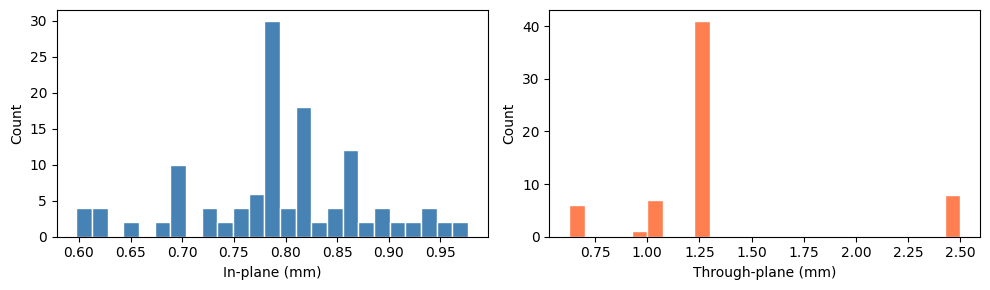

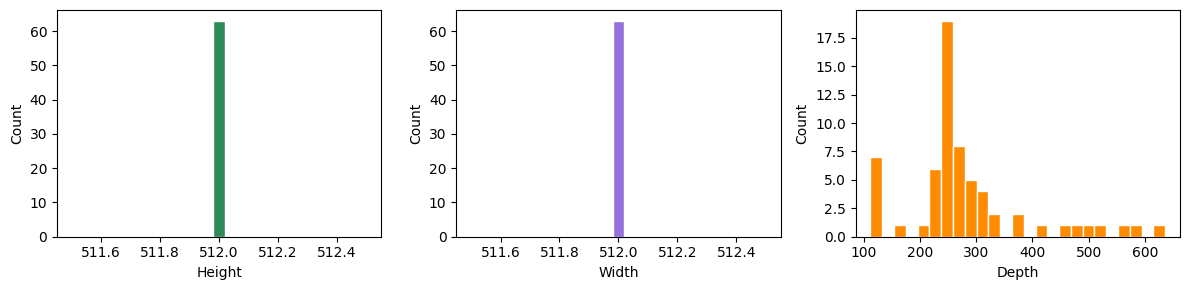

In [20]:
from nibabel.affines import voxel_sizes

in_plane, through_plane = [], []
H_vals, W_vals, D_vals = [], [], []

for p in image_files:
    nii = nib.load(p)
    s = voxel_sizes(nii.affine)
    in_plane.extend([float(s[0]), float(s[1])])
    through_plane.append(float(s[2]))
    sh = nii.shape
    H_vals.append(sh[0])
    W_vals.append(sh[1])
    D_vals.append(sh[2])

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].hist(in_plane, bins=25, color="steelblue", edgecolor="white")
axes[0].set_xlabel("In-plane (mm)")
axes[0].set_ylabel("Count")
axes[1].hist(through_plane, bins=25, color="coral", edgecolor="white")
axes[1].set_xlabel("Through-plane (mm)")
axes[1].set_ylabel("Count")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
axes[0].hist(H_vals, bins=25, color="seagreen", edgecolor="white")
axes[0].set_xlabel("Height")
axes[0].set_ylabel("Count")
axes[1].hist(W_vals, bins=25, color="mediumpurple", edgecolor="white")
axes[1].set_xlabel("Width")
axes[1].set_ylabel("Count")
axes[2].hist(D_vals, bins=25, color="darkorange", edgecolor="white")
axes[2].set_xlabel("Depth")
axes[2].set_ylabel("Count")
plt.tight_layout()
plt.show()

In [21]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

train_img, temp_img, train_lbl, temp_lbl = train_test_split(
    image_files, label_files, test_size=VAL_SPLIT + TEST_SPLIT, random_state=42
)
val_img, test_img, val_lbl, test_lbl = train_test_split(
    temp_img, temp_lbl, test_size=TEST_SPLIT / (VAL_SPLIT + TEST_SPLIT), random_state=42
)

max_H, max_W, max_D = 0, 0, 0
for p in train_img:
    h, w, d = nib.load(p).shape[:3]
    max_H, max_W, max_D = max(max_H, h), max(max_W, w), max(max_D, d)

def pad_or_crop(x, target_shape):
    H, W, D = x.shape[:3]
    tH, tW, tD = target_shape
    if H >= tH:
        start_h = (H - tH) // 2
        x = x[start_h:start_h + tH, :, :]
    if W >= tW:
        start_w = (W - tW) // 2
        x = x[:, start_w:start_w + tW, :]
    if D >= tD:
        start_d = (D - tD) // 2
        x = x[:, :, start_d:start_d + tD]
    H, W, D = x.shape[:3]
    need_h, need_w, need_d = tH - H, tW - W, tD - D
    if need_h > 0 or need_w > 0 or need_d > 0:
        x = np.pad(x, ((0, need_h), (0, need_w), (0, need_d)), mode="constant", constant_values=0)
    return x

class Dataset3D(Dataset):
    def __init__(self, image_paths, label_paths, target_shape):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.target_shape = target_shape

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = nib.load(self.image_paths[idx]).get_fdata()
        msk = nib.load(self.label_paths[idx]).get_fdata()
        img = pad_or_crop(img, self.target_shape)
        msk = pad_or_crop(msk, self.target_shape)
        msk = (msk > 0.5).astype(np.float32)
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        img = np.expand_dims(img.astype(np.float32), axis=0)
        msk = np.expand_dims(msk.astype(np.float32), axis=0)
        return torch.from_numpy(img), torch.from_numpy(msk)

target_shape = (max_H, max_W, max_D)
print(f"Padded/cropped to: {target_shape[0]} x {target_shape[1]} x {target_shape[2]}")
train_ds = Dataset3D(train_img, train_lbl, target_shape)
val_ds = Dataset3D(val_img, val_lbl, target_shape)
test_ds = Dataset3D(test_img, test_lbl, target_shape)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0)